In [1]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.linalg import eigh
import numpy as np
from scipy.ndimage import gaussian_filter
import math
from numpy import linalg as LA

In [2]:
imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)

content_copy = content.copy()
content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

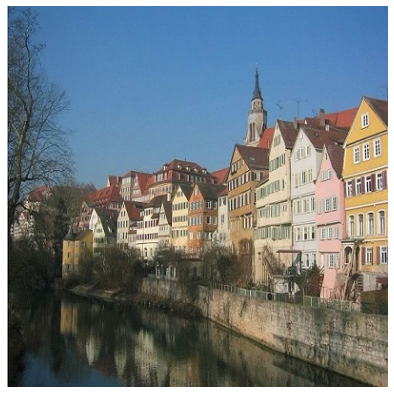

In [3]:
plt.figure(figsize=(15,7))
plt.imshow(content)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

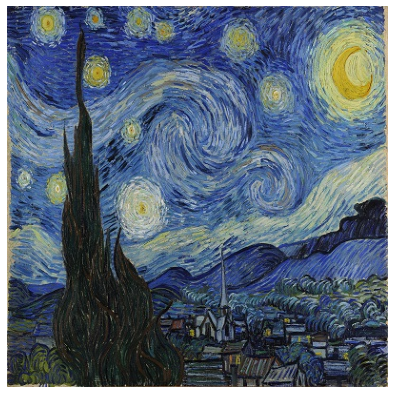

In [4]:
plt.figure(figsize=(15,7))
plt.imshow(style)
plt.axis("off")

### Applying color transfer to content image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


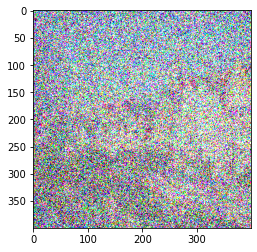

In [5]:
C0 = cv2.GaussianBlur(content, (5, 5), 100)

# 2d image into 1d array
C0 = content.reshape(-1)
S0 = style.reshape(-1)

h0 = imsize
w0 = imsize
c = 3

# Convert to 3D arrays only to use in histogram matching of color
C0 = C0.reshape(h0, w0, c)
S0 = S0.reshape(h0, w0, c)

# COLOUR TRANSFER

# The result of exposure.match_histograms is assigned back to C0[:, :, channel], 
# effectively replacing the pixel values of the content image's specific color channel with 
# new values that match the color distribution of the corresponding color channel in the style image.    

for channel in range(c):
    C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])

C0 = C0.reshape(-1)
X = C0

# INITIALIZING OUTPUT IMAGE WITH NOISE - this is done to prevent repetitive patches 

X = X + np.max(X) * np.random.randn(X.size)
X = X.reshape(h0, w0, c)

plt.imshow(X)
X = X.reshape(-1)

In [6]:
L = 4

hall =  np.ones((400, 400, 3))
mask0 = np.ones((400, 400))

hallcoeff = 0
wcoeff = 0

C_scaled = cv2.resize(C0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
S_scaled = cv2.resize(S0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

C = C_scaled.reshape(-1)
S = S_scaled.reshape(-1)

h = np.ceil(h0/L).astype(int)
w = np.ceil(w0/L).astype(int)

X = cv2.resize(X.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

# Halls is 400 x 400 x 3 array of 1s 
halls = cv2.resize(hall, (0,0), fx=1/L, fy=1/L)

X = X.reshape(-1)

Q_size = 36 # patch_size
Pstride = 4

S = S.reshape((h, w, c))

# here basically we are creating a 3d array of zeroes of , and note that 
# h-qize+1 is the number of starting points we can have along vertical direction 
# w-qsize+1 is the number of starting points we can have along horizontal direction 
# then to find total number of steps we divide by Pstride .

numpatches =(int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) 
numpatches = numpatches * 4  # this is for all four rotations

P = np.zeros((c * Q_size * Q_size, numpatches))


for k in range(0, h - Q_size + 1, Pstride):
            for j in range(0, w - Q_size + 1, Pstride):

                # extracting current patch
                # The third part, represented by :, means that we are including all channels in this slice
                patch = S[k:k+Q_size, j:j+Q_size, :]

                # Compare for each of the 4 orientations
                for l in range(4):
                    temp = np.rot90(patch, k=l)
                    # P[:, (int(k / Pstride) - 1) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride) - 1) * 4 + l + 1] = temp.flatten()
                    P[:,(int(k/Pstride)-1)*(int( ((w-Q_size+1)-1)/Pstride )+ 1)*4 + (int(j/Pstride)-1)*4 + l + 1] = temp.flatten()

                    # This is calculating the position in the P patch to which we want to assign the temp patch

                    # k/Pstride - 1 = starting index
                    # ((w - Q_size + 1)/Pstride + 1) * 4 = number of starting positions along length, * 4 for number of rotations
                    # + l is for current rotation in P
                    # + 1 to adjust for indexing
        
S = S.reshape(-1)

# Putting it together, P = np.zeros((c * Q_size * Q_size, numpatches)) creates a matrix P 
# where each column corresponds to a patch, and each row represents a feature extracted from that patch.


In [7]:
# mp = np.mean(P, axis=1)
# P = P - np.tile(mp[:, np.newaxis], (1, P.shape[1]))

# Example usage
Q = [[1,2,3], [1,0,3], [1,2,4]]

# take mean along rows
mq = np.mean(Q, axis = 1)
print(mq)

# take mean along columns
mq = np.mean(Q, axis = 0)
print(mq)

# We need to calculate along columns
print(mq.shape)


[2.         1.33333333 2.33333333]
[1.         1.33333333 3.33333333]
(3,)


In [8]:
# Q = np.array([[1,2,3], [1,0,3], [1,2,4]])
mp = np.mean(P, axis=1)
mp = mp.reshape(-1,1)

num_cols = P.shape[1]
replicated = np.repeat(mp, num_cols, axis=1)
# print(replicated)

P = P - replicated
# print(np.sum(P[0]))
# print(P.shape) # (3888, 1156)

CoP = np.dot(P, P.T)
# print(CoP.shape)     #3888 * 3888, symmetric matrix - checked

D, V = np.linalg.eigh(CoP)
sorted_indices = np.argsort(D)[::-1]

# Sort eigenvalues and eigenvectors using the sorted indices
D_sorted = D[sorted_indices]
V_sorted = V[:, sorted_indices]

eig_idx = 1
energy = 0

# To store cumulative energy
total_energy = sum(D_sorted)

for i in range(len(D_sorted)):
    energy += D_sorted[i]
    if energy >= 0.95 * total_energy:
        eig_idx = i
        break
    
# Retain only upto eig_idx number of eigenvectors

Vp = V_sorted[:, :eig_idx]
print(Vp.shape)  # (3888, 512)
Pp = np.dot(Vp.T, P)  
print(Pp.shape) # (512, 1156)


(3888, 512)
(512, 1156)


### Style Fusion

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


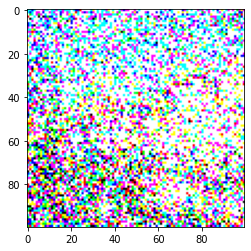

In [9]:
X = hallcoeff * halls.flatten() + (1 - hallcoeff) * X.flatten()
X = X.reshape(h,w,c)
plt.imshow(X)

### Patch Matching

In [13]:
def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):
    X.flatten()
    S = S.reshape((h, w, c))
    RX = X[R.astype(bool)]

    print("RX Shape ", RX.shape)
    # RX Shape  (3888,)

    RXp = np.dot(Vp.T, (RX - mp))
    print("Rxp shape ", RXp.shape)
    # print(R.shape)
    # print(X.shape)

    num_cols = Pp.shape[1]
    replicated = np.repeat(RXp, num_cols, axis=1)   
    print(replicated.shape)
    print(Pp.shape)
    # dif = replicated - Pp

    # sqr = np.sum(dif**2, axis=0)
    # sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(len(sqr))
    # idx = np.argmin(sqr)

    # ls, ks = np.unravel_index(np.ceil(idx/4), ((np.floor(((w-Q_size+1)-1)/Pstride)+1), (np.floor(((h-Q_size+1)-1)/Pstride)+1)))
    # ks = (ks - 1) * Pstride + 1
    # ls = (ls - 1) * Pstride + 1
    # ang= np.mod(idx+3,4)

    # # Assuming `S`, `ks`, `ls`, and `Q_size` are defined
    # z = S[ks:ks+Q_size, ls:ls+Q_size, :]  # Extract the region of interest
    # z = z.flatten()  # Flatten the 3D array into a 1D array

    # # return ks,ls, z, ang
    # return z

    return 2


In [14]:
gap = 6
n = Q_size
X = X.reshape(-1)

num_patch = (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)
Rall = np.zeros((h * w * c, num_patch))
z = np.zeros((c * n**2, num_patch))

for i in range(0, h-Q_size+1, gap):
    for j in range(0, w-Q_size+1, gap):
        R = np.zeros((h, w, c))

        R[i:i+Q_size, j:j+Q_size, :] = 1
        R = R.reshape(-1)
        
        Rall[:, (math.ceil(i / gap) - 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1) + math.ceil(j / gap)] = R
        # zij = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
        num = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)

RX Shape  (3888,)
Rxp shape  (512, 3888)
(591872, 3888)
(512, 1156)
RX Shape  (3888,)
Rxp shape  (512, 3888)
(591872, 3888)
(512, 1156)
RX Shape  (3888,)
Rxp shape  (512, 3888)
(591872, 3888)
(512, 1156)
RX Shape  (3888,)
